# BurkPx 2.0 Data Wrangling and Model Preparation

## Python Libraries

In [22]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import missingno as msno
import numpy as np
# from pandas_profiling import ProfileReport
# https://stackoverflow.com/questions/64137932/create-interaction-term-in-scikit-learn

## Functions

In [2]:
def OverSampler(parentDIR,df, xfilename, yfilename):
    # Oversample small class to balanced data
    # Using constant random state below for reproducibility
    os.chdir(parentDIR)
    df = df.dropna(how='all')
    X = df.drop(['index','PatientID', 'TimeGroup','SerumID', 'Status', 'Rep'], axis=1).copy().reset_index(drop=True)
    X = pd.get_dummies(X)
    Y = df.Status.copy()

    ros = RandomOverSampler(random_state=0)
    Xoversampled, Yoversampled = ros.fit_resample(X, Y)
    Xoversampled.to_csv(xfilename, sep='\t')
    Yoversampled.to_csv(yfilename, sep='\t')
    return Xoversampled, Yoversampled

## Loading and concatenating RAW data

In [3]:
parentdir = os.getcwd()
testdata = pd.read_excel('Human Training and Testing sets for model.xlsx', sheet_name='Human Testing')
traindata = pd.read_excel('Human Training and Testing sets for model.xlsx', sheet_name='Human Training')
Full = pd.concat([testdata, traindata ]).reset_index()
Full.to_csv('Concatenated_RAW.txt', sep='\t')

### Checking for missing values

In [4]:
Full.isna().sum()
missing = Full[Full.isna().any(axis=1)]
Full.dropna(inplace=True)

### grouping Data
* finding average values from technical replicates. (Decided to use whole data and not average). 
* dropping whole cell lysate as it is not informative to antigens present for Burk infection.

In [9]:
Fullavg = Full.groupby(['PatientID', 'SerumID', 'TimeGroup', 'Status', 'Type']).mean().reset_index()
Clean = Fullavg.drop(['index', 'MSHR5855.WCL'], axis=1)
for name, group in Clean.groupby("Type"):
    print(name)
    print(Clean.Status.value_counts())

for name, group in group.groupby("Type"):
    print(name)
    print(Clean.TimeGroup.value_counts())
Clean.to_csv('CleanedData.txt', sep='\t')

IgG
Melioid     980
Negative    798
Name: Status, dtype: int64
IgM
Melioid     980
Negative    798
Name: Status, dtype: int64
IgM
Healthy    798
Week4+     682
Week2      116
Week3       92
Week1       80
Prior       10
Name: TimeGroup, dtype: int64


## Testing for Multicollinearity
### Whole Data Analysis

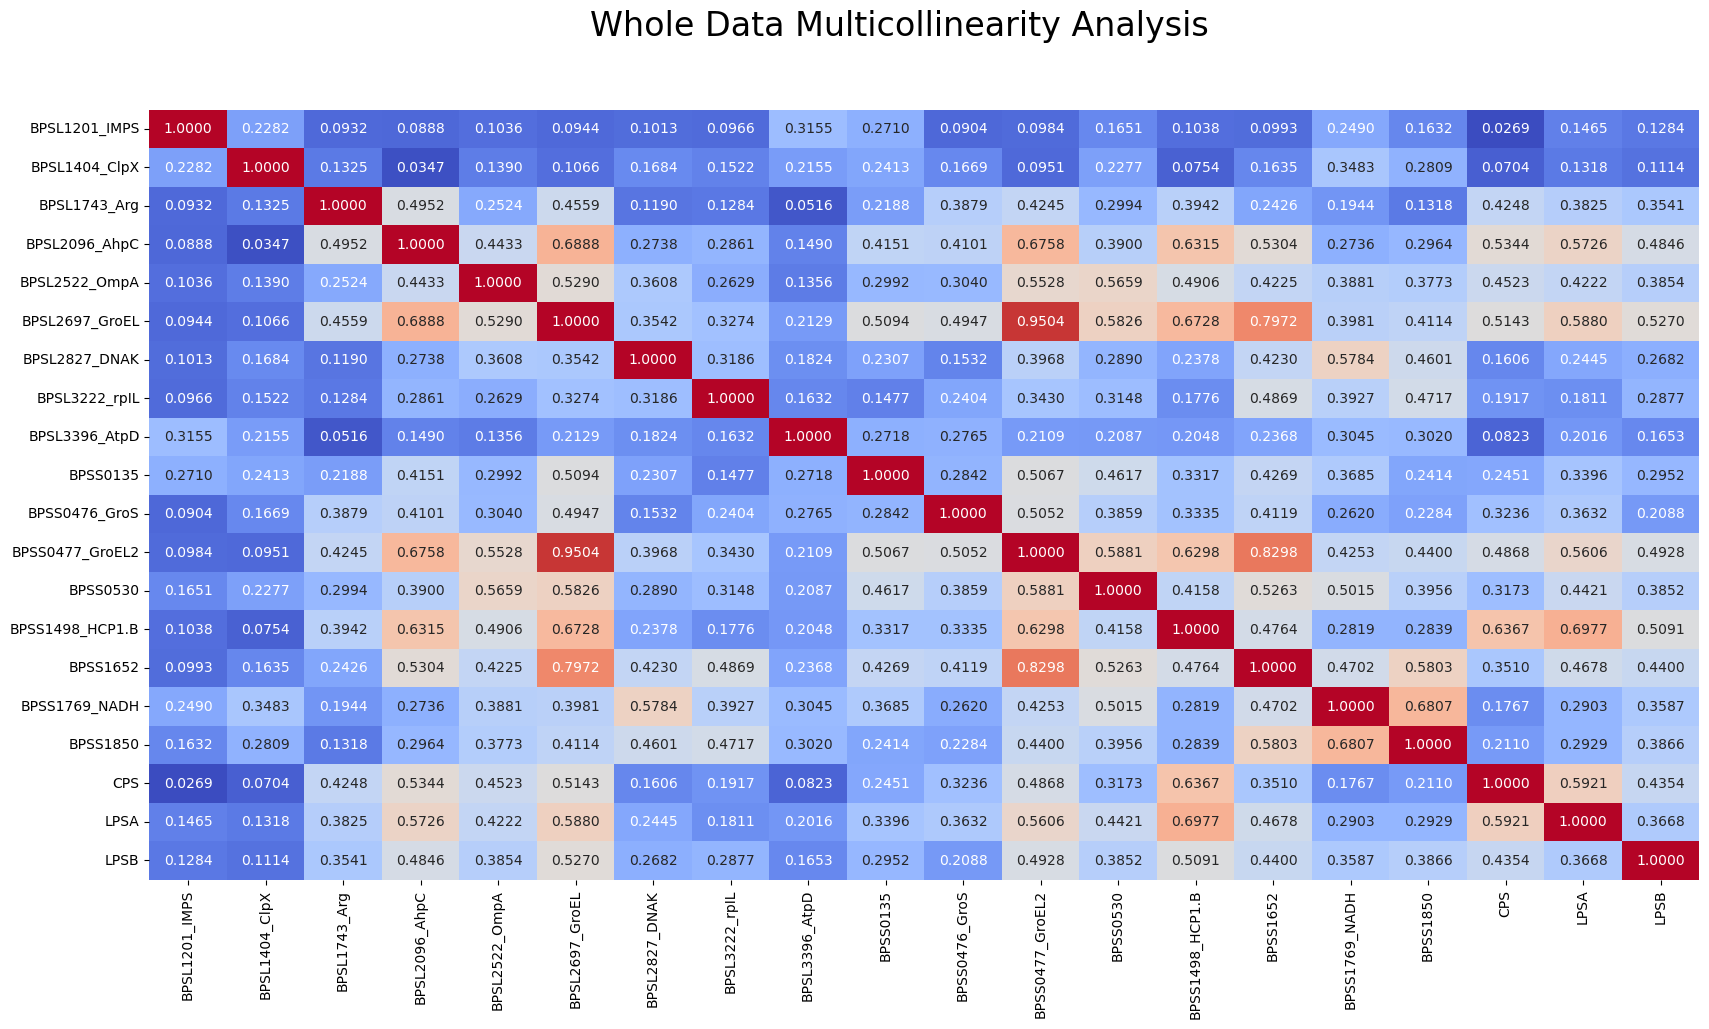

In [28]:
if not os.path.isdir('ExploratoryAnalysis'):
    os.makedirs('ExploratoryAnalysis')
os.chdir('ExploratoryAnalysis')

CorrDF = Clean.drop(['PatientID', 'SerumID', 'TimeGroup', 'Status', 'Type', 'Rep'], axis=1)
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(CorrDF.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
fig.suptitle('Whole Data Multicollinearity Analysis', fontsize=24)
fig.savefig('WholeDatacorrplot.png', dpi=300, bbox_inches='tight')

vifs = pd.Series(np.linalg.inv(CorrDF.corr().to_numpy()).diagonal(), 
                 index=CorrDF.columns, 
                 name='VIF')
vifs.to_csv('WholeDataVIF.txt',sep='\t')

In [27]:
os.chdir(parentdir)

### By TimeGroup Analysis

/tmp/ipykernel_2903814/2976528121.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(group.corr(method='pearson'), annot=True, fmt='.4f',
/tmp/ipykernel_2903814/2976528121.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(group.corr(method='pearson'), annot=True, fmt='.4f',
/tmp/ipykernel_2903814/2976528121.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(group.corr(method='pearson'), annot=True, fmt='.4f',
/tmp/ipykernel_2903814/29765

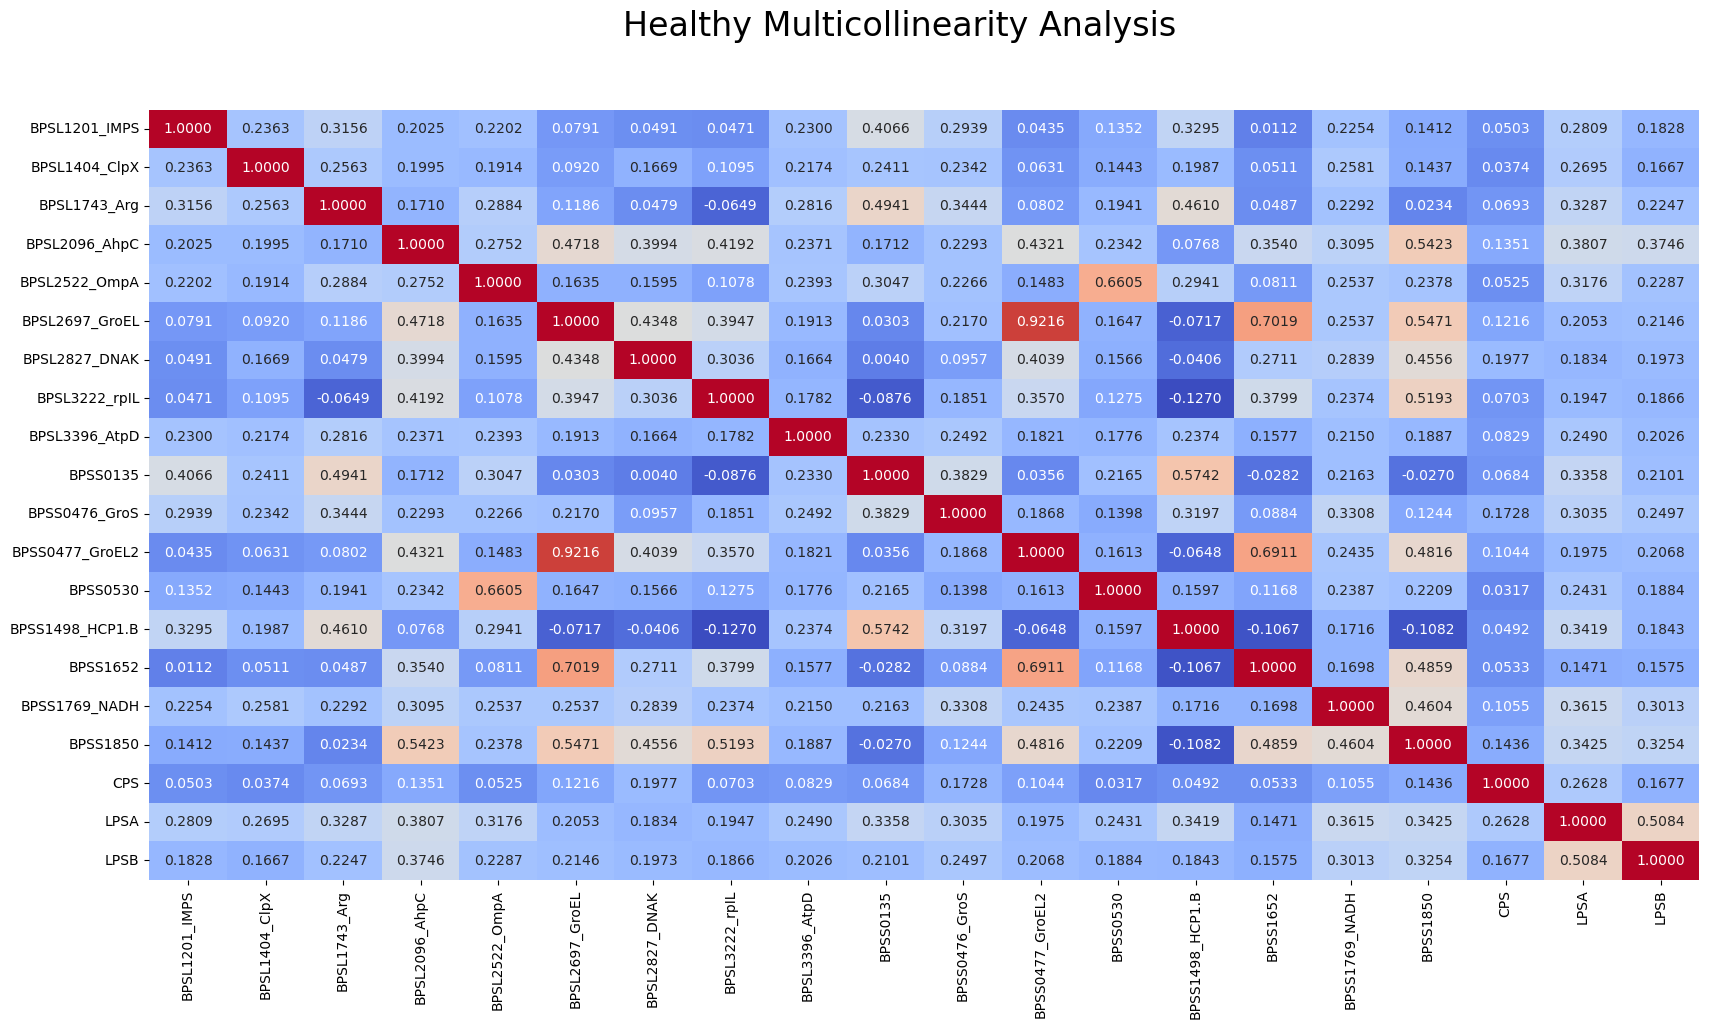

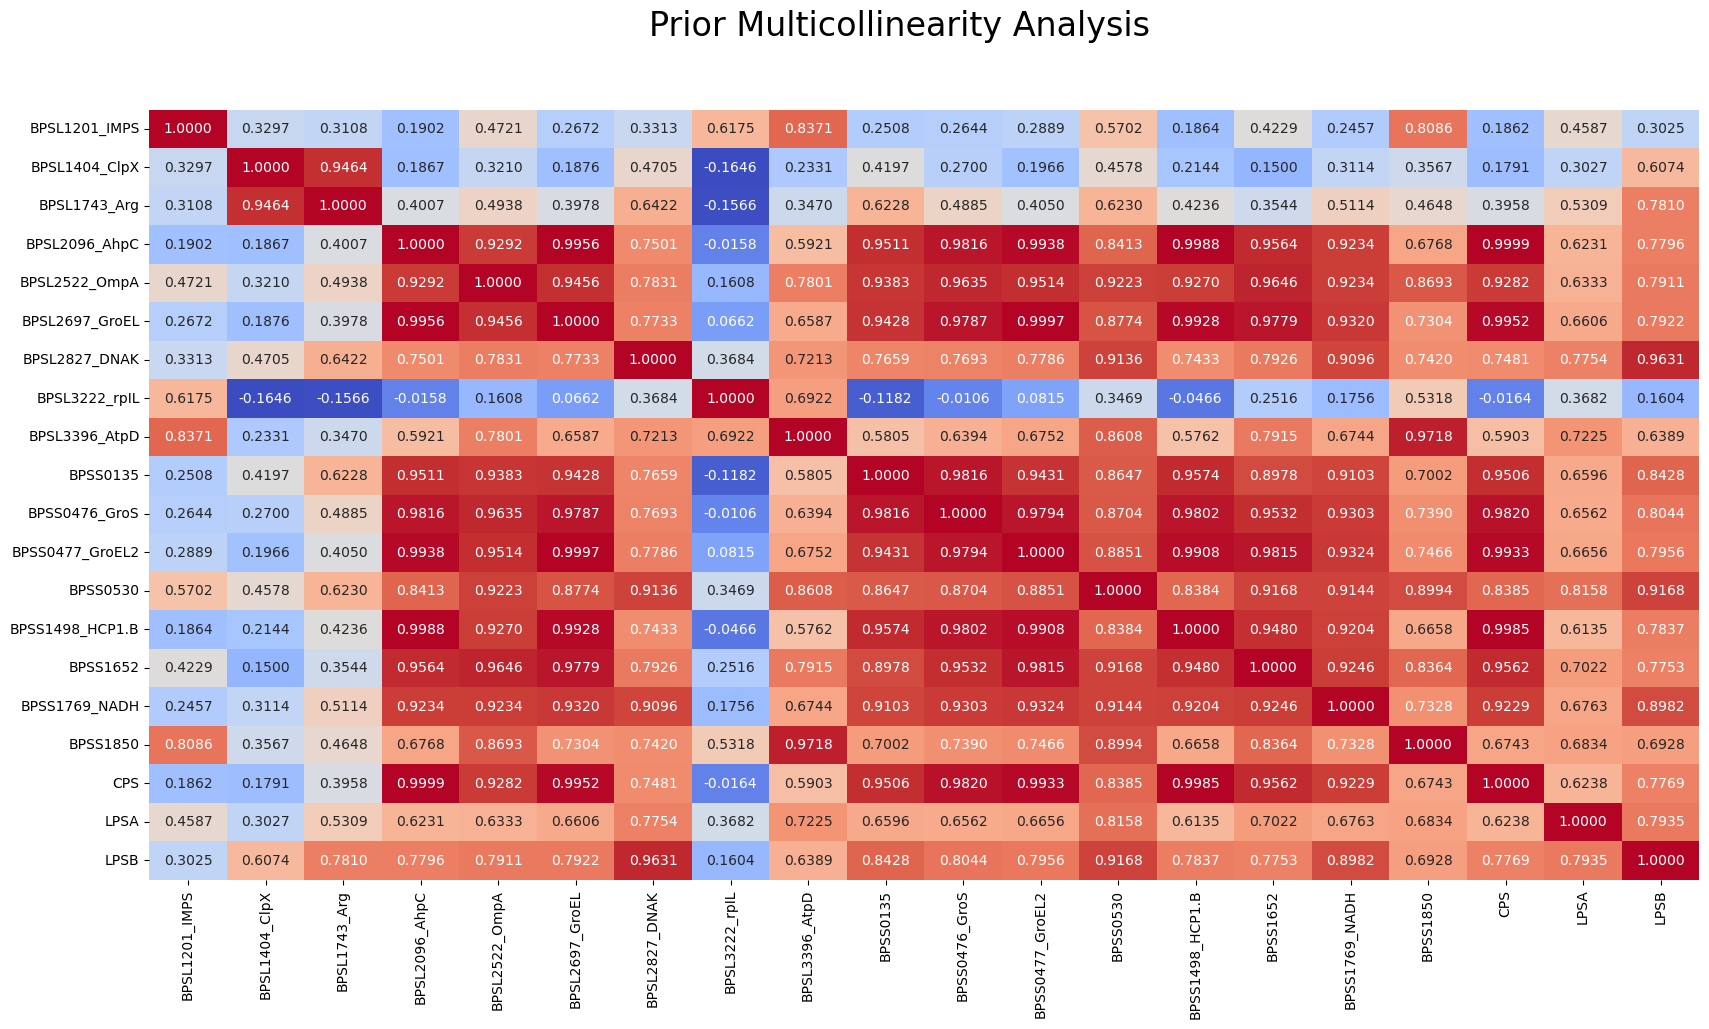

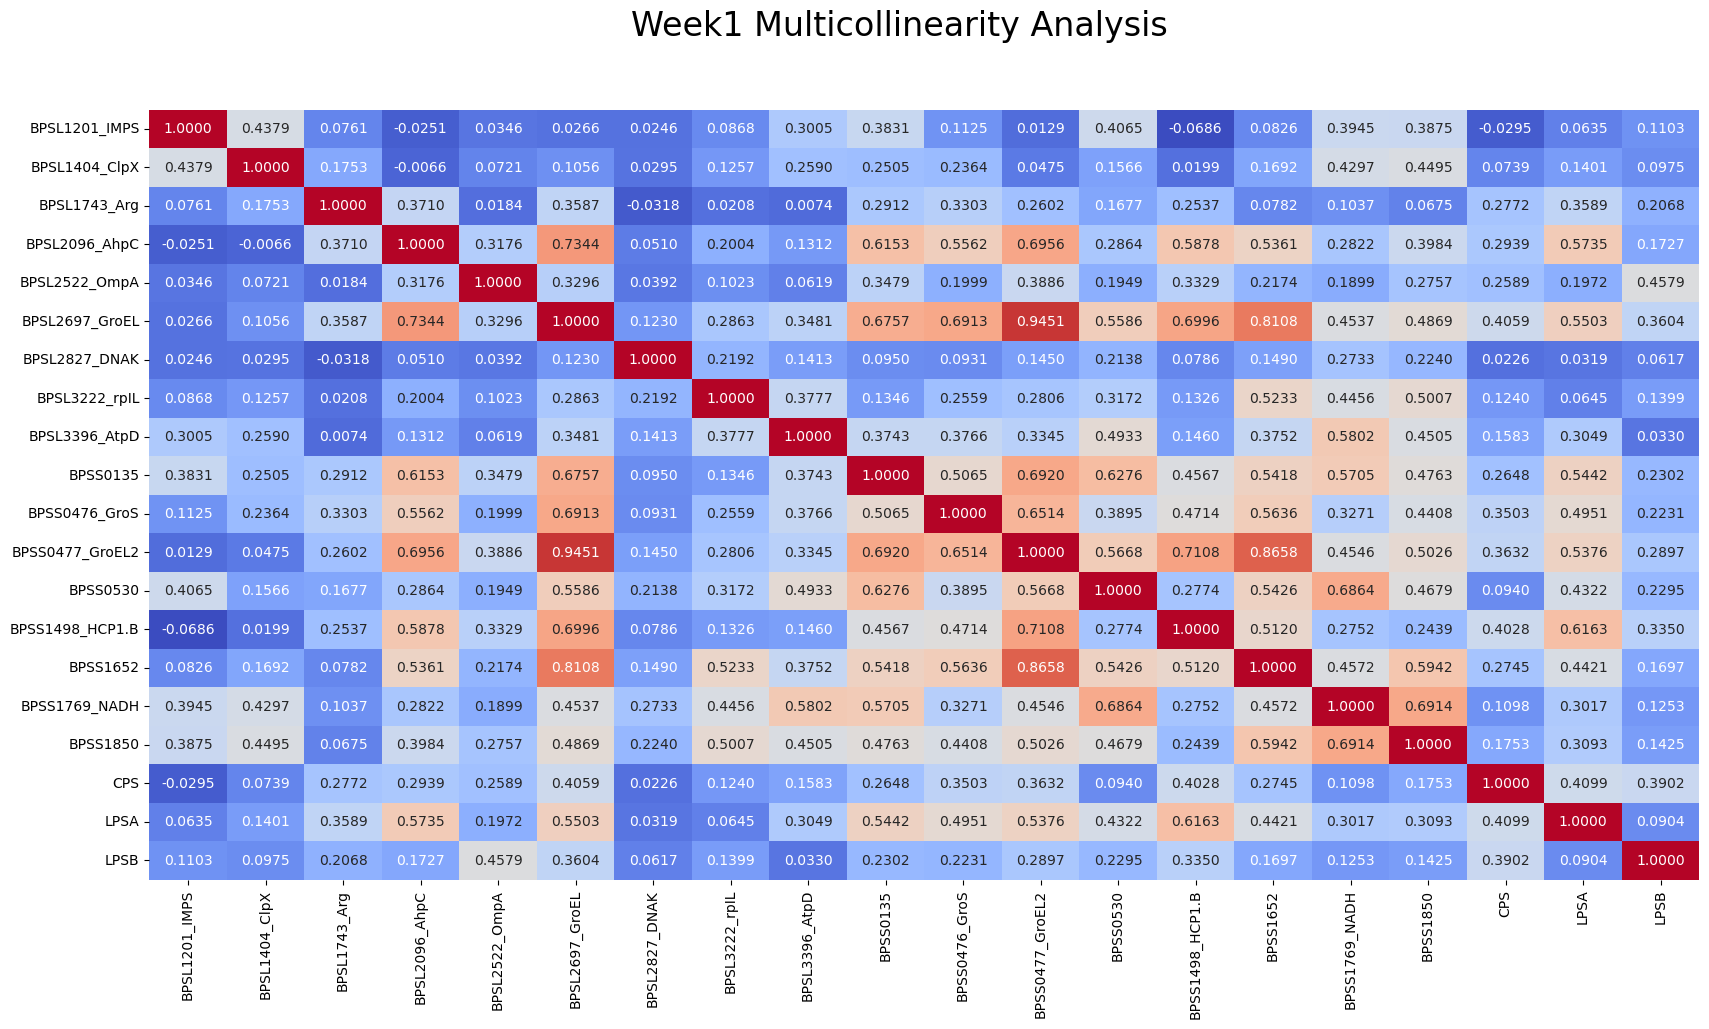

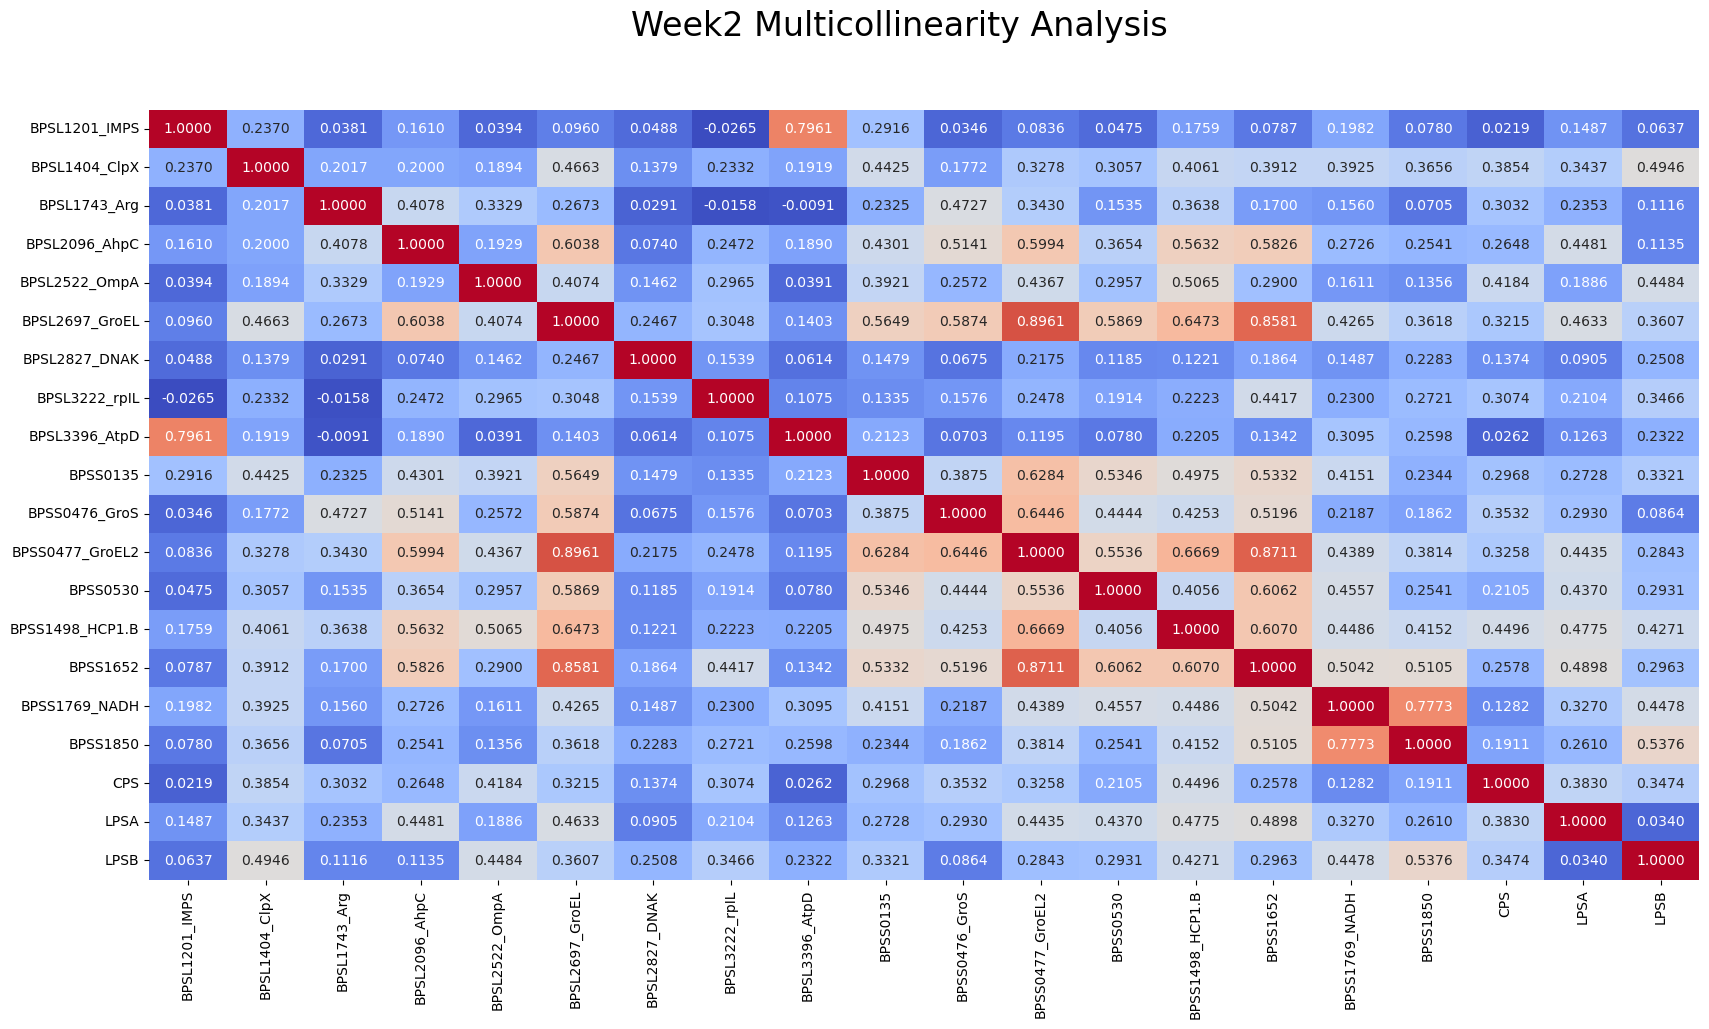

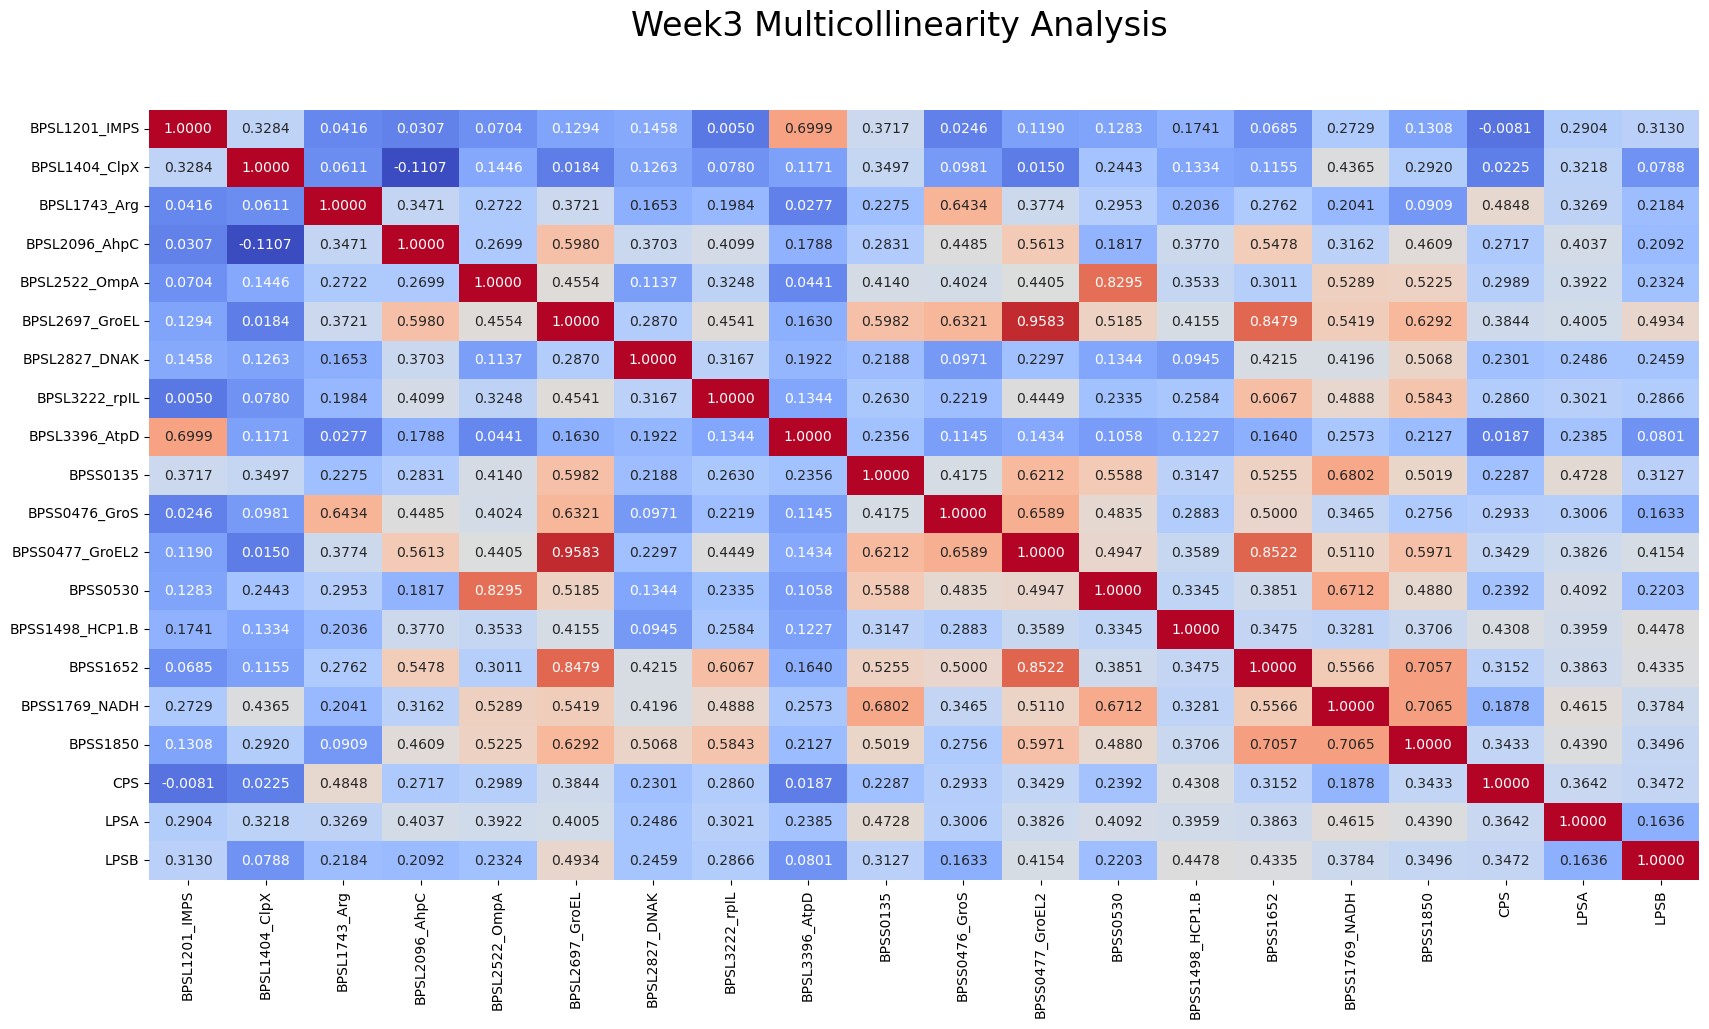

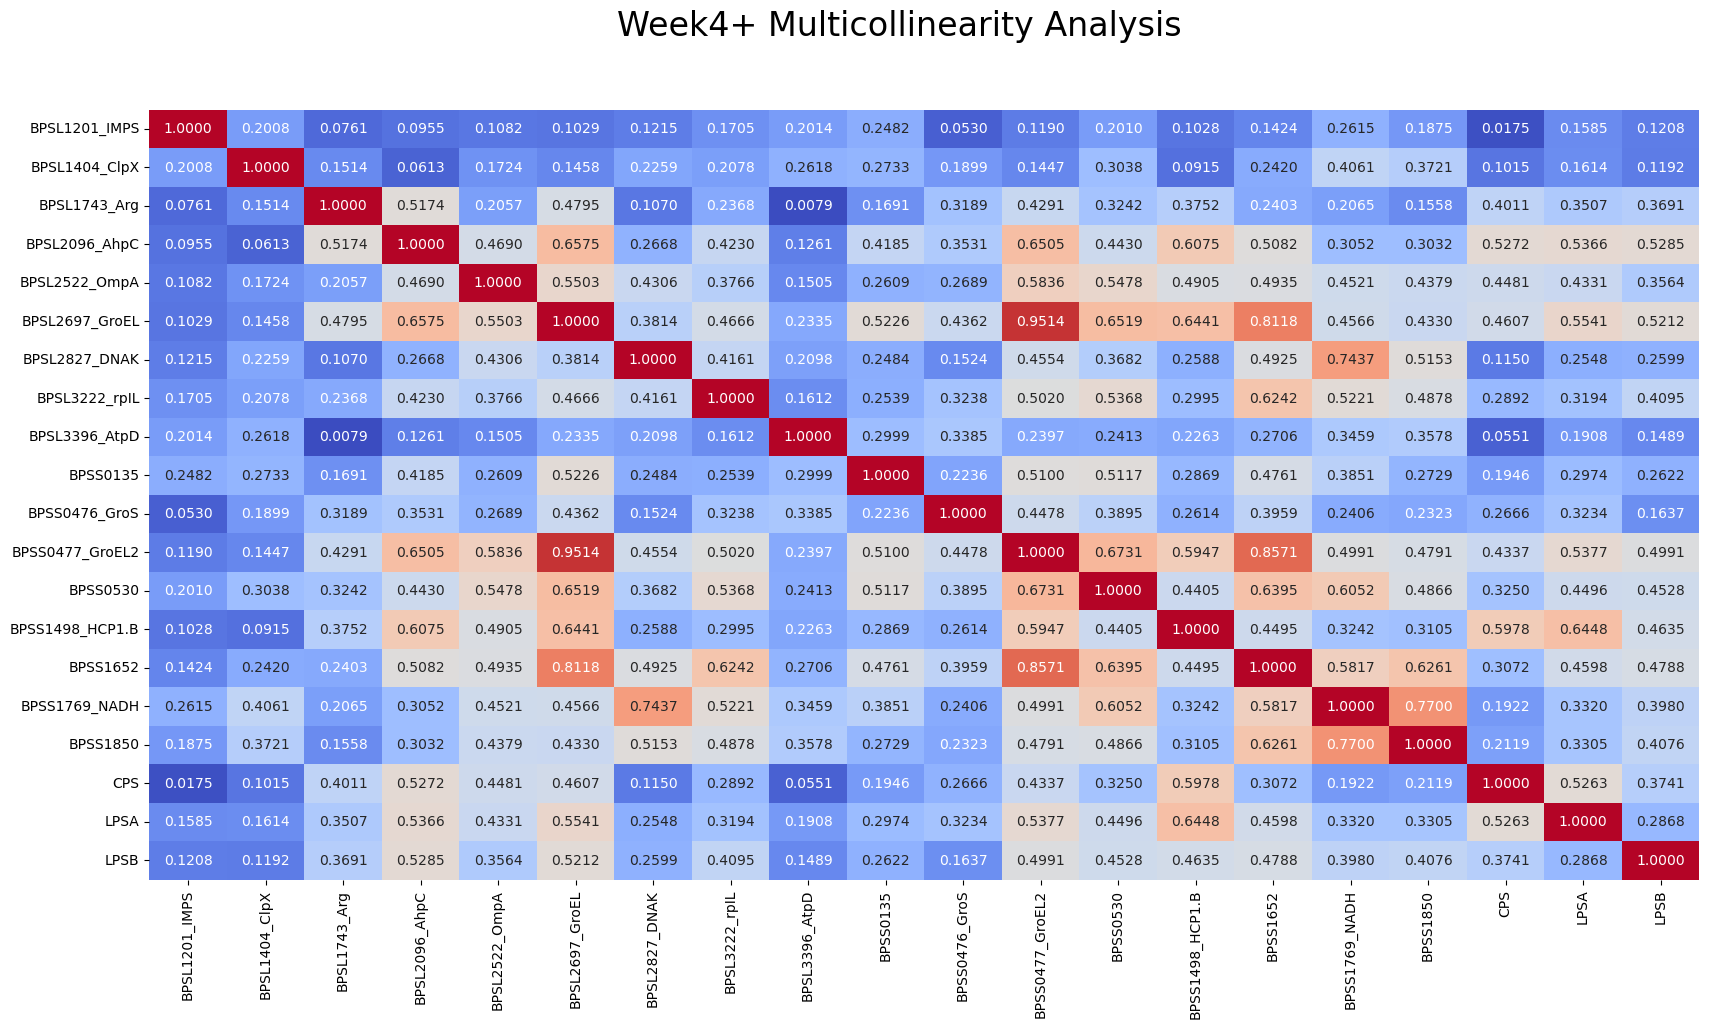

In [31]:
CorrDF = Clean.drop(['PatientID', 'SerumID', 'Status', 'Type', 'Rep'], axis=1)

for name, group in CorrDF.groupby('TimeGroup'):

    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(group.corr(method='pearson'), annot=True, fmt='.4f', 
                cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
    fig.suptitle(str(name)+' Multicollinearity Analysis', fontsize=24)
    fig.savefig(str(name)+'corrplot.png', dpi=300, bbox_inches='tight')

    group.drop('TimeGroup', axis=1, inplace=True)
    vifs = pd.Series(np.linalg.inv(group.corr().to_numpy()).diagonal(), 
                 index=group.columns, 
                 name='VIF')
    vifs.to_csv(str(name)+'VIF.txt',sep='\t')   
    

### Grouping with Healthy added to each

/tmp/ipykernel_2903814/1035188979.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(week4.corr(method='pearson'), annot=True, fmt='.4f',
/tmp/ipykernel_2903814/1035188979.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week4.drop('TimeGroup', axis=1, inplace=True)


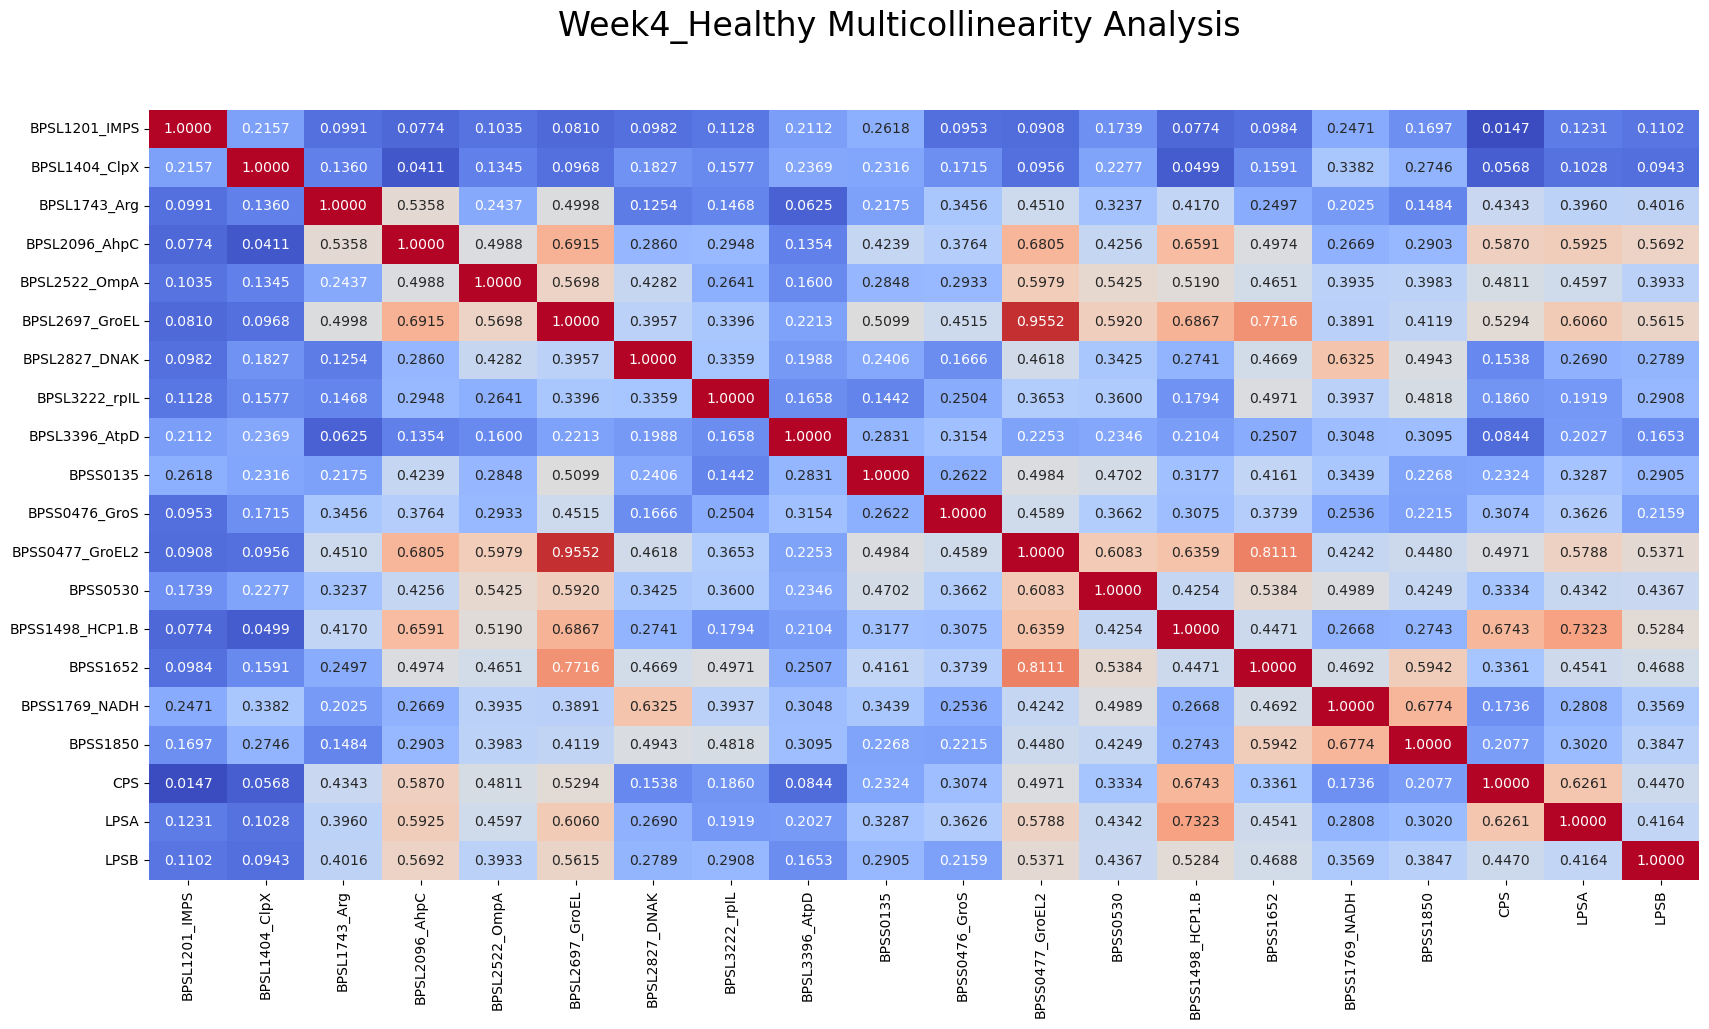

In [39]:
week1 = CorrDF.loc[(CorrDF['TimeGroup']=='Week1') | (CorrDF['TimeGroup']=='Healthy')]
week2 = CorrDF.loc[(CorrDF['TimeGroup']=='Week2') | (CorrDF['TimeGroup']=='Healthy')]
week3 = CorrDF.loc[(CorrDF['TimeGroup']=='Week3') | (CorrDF['TimeGroup']=='Healthy')]
week4 = CorrDF.loc[(CorrDF['TimeGroup']=='Week4+') | (CorrDF['TimeGroup']=='Healthy')]


fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(week4.corr(method='pearson'), annot=True, fmt='.4f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
fig.suptitle('Week4_Healthy Multicollinearity Analysis', fontsize=24)
fig.savefig('Week4_Healthycorrplot.png', dpi=300, bbox_inches='tight')

week4.drop('TimeGroup', axis=1, inplace=True)
vifs = pd.Series(np.linalg.inv(week4.corr().to_numpy()).diagonal(), 
                index=week4.columns, 
                name='VIF')
vifs.to_csv('Week4_Healthy_VIF.txt',sep='\t')   

In [23]:
os.chdir(parentdir)

### NonResampled Data Splitting:
* Generating separate left-out validation sets (10%) for each Week1-Week4.
* Generating separate data for Week1-Week4 

In [ ]:
os.chdir(parentdir)
if not os.path.isdir('NonResampled'):
    os.makedirs('NonResampled')
os.chdir('NonResampled')
NonresDir = os.getcwd()

for name, group in Clean.groupby("Type"): # add SerumID to group
    print(name)
    os.chdir(NonresDir)
    if not os.path.isdir(name):
        os.makedirs(name)
    os.chdir(name)
    TypeDir = os.getcwd()
    if not os.path.isdir('ValidationSet'):
        os.makedirs('ValidationSet')
    os.chdir('ValidationSet')
    
    Week4 = group.loc[(group['TimeGroup']=='Week4+')].copy().sample(frac=0.1, random_state=0)
    Week3 = group.loc[(group['TimeGroup']=='Week3')].copy().sample(frac=0.1, random_state=0)
    Week2 = group.loc[(group['TimeGroup']=='Week2')].copy().sample(frac=0.1, random_state=0)
    Week1 = group.loc[(group['TimeGroup']=='Week1')].copy().sample(frac=0.1, random_state=0)
    prior = group.loc[(group['TimeGroup']=='Prior')].copy().sample(frac=0.1, random_state=0)
    Negative = group.loc[(group['TimeGroup']=='Healthy')].copy().sample(frac=0.1, random_state=0)

    ValidationSet = pd.concat([Week1, Week2, Week3, Week4, prior, Negative])
    ValidationSet.to_csv('ValidationSet.txt', sep='\t')
    print(ValidationSet.TimeGroup.value_counts())

    group.drop(Week1.index, inplace=True)
    group.drop(Week2.index, inplace=True)
    group.drop(Week3.index, inplace=True)
    group.drop(Week4.index, inplace=True)
    group.drop(Negative.index, inplace=True)
    group.drop(prior.index, inplace=True)


    os.chdir(TypeDir)
    Week4 = group.loc[(group['TimeGroup']=='Week4+')|(group['TimeGroup']=='Healthy')].copy()
    Week3 = group.loc[(group['TimeGroup']=='Week3')|(group['TimeGroup']=='Healthy')].copy()
    Week2 = group.loc[(group['TimeGroup']=='Week2')|(group['TimeGroup']=='Healthy')].copy()
    Week1 = group.loc[(group['TimeGroup']=='Week1')|(group['TimeGroup']=='Healthy')].copy()
    Prior = group.loc[(group['TimeGroup']=='Prior')|(group['TimeGroup']=='Healthy')].copy()
    Week4.to_csv('Week4_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    Week3.to_csv('Week3_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    Week2.to_csv('Week2_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    Week1.to_csv('Week1_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    Prior.to_csv('Prior_'+str(name)+'_PosNeg_grouped.txt', sep='\t')

In [ ]:
os.chdir(NonresDir)

igg4 = pd.read_csv('IgG/Week4_IgG_PosNeg_grouped.txt')
igg3 = pd.read_csv('IgG/Week3_IgG_PosNeg_grouped.txt')
igg2 = pd.read_csv('IgG/Week2_IgG_PosNeg_grouped.txt')
igg1 = pd.read_csv('IgG/Week1_IgG_PosNeg_grouped.txt')

igm4 = pd.read_csv('IgM/Week4_IgM_PosNeg_grouped.txt')
igm3 = pd.read_csv('IgM/Week3_IgM_PosNeg_grouped.txt')
igm2 = pd.read_csv('IgM/Week2_IgM_PosNeg_grouped.txt')
igm1 = pd.read_csv('IgM/Week1_IgM_PosNeg_grouped.txt')

if not os.path.isdir('IgGM'):
    os.makedirs('IgGM')
os.chdir('IgGM')
iggm1 = pd.concat([igg1,igm1])
iggm2 = pd.concat([igg2,igm2])
iggm3 = pd.concat([igg3,igm3])
iggm4 = pd.concat([igg4,igm4])

iggm1.to_csv("Week1_IgGM_PosNeg_grouped.txt", sep='\t')
iggm2.to_csv("Week2_IgGM_PosNeg_grouped.txt", sep='\t')
iggm3.to_csv("Week3_IgGM_PosNeg_grouped.txt", sep='\t')
iggm4.to_csv("Week4_IgGM_PosNeg_grouped.txt", sep='\t')

### OverSampled Data Cleaning and Splitting
* Generating separate left-out validation sets (10%) for each Week1-Week4.
* Generating separate data for Week1-Week4 
* Oversampling the to be modeled Week1-Week4 to increase the minority class to balanced with the majority class.
* Oversampling the validation Week1-Week4 to increase the minority class to balanced with the majority class.


In [8]:
os.chdir(parentdir)
if not os.path.isdir('OverSampled'):
    os.makedirs('OverSampled')
os.chdir('OverSampled')
OverDir = os.getcwd()

for name, group in Clean.groupby("Type"): # add SerumID to group
    print(name)
    os.chdir(OverDir)
    if not os.path.isdir(name):
        os.makedirs(name)
    os.chdir(name)
    TypeDir = os.getcwd()
    if not os.path.isdir('ValidationSet'):
        os.makedirs('ValidationSet')
    os.chdir('ValidationSet')

    Week4 = group.loc[(group['TimeGroup']=='Week4+')].copy().sample(frac=0.1, random_state=0)
    Week3 = group.loc[(group['TimeGroup']=='Week3')].copy().sample(frac=0.1, random_state=0)
    Week2 = group.loc[(group['TimeGroup']=='Week2')].copy().sample(frac=0.1, random_state=0)
    Week1 = group.loc[(group['TimeGroup']=='Week1')].copy().sample(frac=0.1, random_state=0)
    prior = group.loc[(group['TimeGroup']=='Prior')].copy().sample(frac=0.1, random_state=0)
    Negative = group.loc[(group['TimeGroup']=='Healthy')].copy().sample(frac=0.1, random_state=0)

    x1, y1 = OverSampler(os.getcwd(),pd.concat([Week1,Negative]), 'week1_'+str(name)+'predictor.txt', 'week1_'+str(name)+'response.txt')
    x2, y2 = OverSampler(os.getcwd(),pd.concat([Week2,Negative]), 'week2_'+str(name)+'predictor.txt', 'week2_'+str(name)+'response.txt')
    x3, y3 = OverSampler(os.getcwd(),pd.concat([Week3,Negative]), 'week3_'+str(name)+'predictor.txt', 'week3_'+str(name)+'response.txt')
    x4, y4 = OverSampler(os.getcwd(),pd.concat([Week4,Negative]), 'week4_'+str(name)+'predictor.txt', 'week4_'+str(name)+'response.txt')

    # ValidationSet = pd.concat([Week1, Week2, Week3, Week4, prior, Negative])
    # ValidationSet.to_csv('ValidationSet.txt', sep='\t')
    # print(ValidationSet.TimeGroup.value_counts())


    group.drop(Week1.index, inplace=True)
    group.drop(Week2.index, inplace=True)
    group.drop(Week3.index, inplace=True)
    group.drop(Week4.index, inplace=True)
    group.drop(Negative.index, inplace=True)
    group.drop(prior.index, inplace=True)


    os.chdir(TypeDir)
    Week4 = group.loc[(group['TimeGroup']=='Week4+')|(group['TimeGroup']=='Healthy')].copy()
    Week3 = group.loc[(group['TimeGroup']=='Week3')|(group['TimeGroup']=='Healthy')].copy()
    Week2 = group.loc[(group['TimeGroup']=='Week2')|(group['TimeGroup']=='Healthy')].copy()
    Week1 = group.loc[(group['TimeGroup']=='Week1')|(group['TimeGroup']=='Healthy')].copy()
    Prior = group.loc[(group['TimeGroup']=='Prior')|(group['TimeGroup']=='Healthy')].copy()

    print(Week4.Status.value_counts())
    
    X4, Y4 = OverSampler(TypeDir, Week4, 'W4_predictor.txt', 'W4_response.txt')
    X3, Y3 = OverSampler(TypeDir, Week3, 'W3_predictor.txt', 'W3_response.txt')
    X2, Y2 = OverSampler(TypeDir, Week2, 'W2_predictor.txt', 'W2_response.txt')
    X1, Y1 = OverSampler(TypeDir, Week1, 'W1_predictor.txt', 'W1_response.txt')


    # Week4.to_csv('Week4_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    # Week3.to_csv('Week3_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    # Week2.to_csv('Week2_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    # Week1.to_csv('Week1_'+str(name)+'_PosNeg_grouped.txt', sep='\t')
    # Prior.to_csv('Prior_'+str(name)+'_PosNeg_grouped.txt', sep='\t')

IgG
Negative    646
Melioid     435
Name: Status, dtype: int64
IgM
Negative    646
Melioid     432
Name: Status, dtype: int64


In [12]:
os.chdir(OverDir)

igg4p = pd.read_csv('IgG/W4_predictor.txt', sep='\t')
igg3p = pd.read_csv('IgG/W3_predictor.txt', sep='\t')
igg2p = pd.read_csv('IgG/W2_predictor.txt', sep='\t')
igg1p = pd.read_csv('IgG/W1_predictor.txt', sep='\t')

igg4r = pd.read_csv('IgG/W4_response.txt', sep='\t')
igg3r = pd.read_csv('IgG/W3_response.txt', sep='\t')
igg2r = pd.read_csv('IgG/W2_response.txt', sep='\t')
igg1r = pd.read_csv('IgG/W1_response.txt', sep='\t')

igm4p = pd.read_csv('IgM/W4_predictor.txt', sep='\t')
igm3p = pd.read_csv('IgM/W3_predictor.txt', sep='\t')
igm2p = pd.read_csv('IgM/W2_predictor.txt', sep='\t')
igm1p = pd.read_csv('IgM/W1_predictor.txt', sep='\t')

igm4r = pd.read_csv('IgM/W4_response.txt', sep='\t')
igm3r = pd.read_csv('IgM/W3_response.txt', sep='\t')
igm2r = pd.read_csv('IgM/W2_response.txt', sep='\t')
igm1r = pd.read_csv('IgM/W1_response.txt', sep='\t')

if not os.path.isdir('IgGM'):
    os.makedirs('IgGM')
os.chdir('IgGM')
iggm1p = pd.concat([igg1p,igm1p]).reset_index(drop=True)
iggm1r = pd.concat([igg1r,igm1r]).reset_index(drop=True).drop('Unnamed: 0', axis=1)
iggm2p = pd.concat([igg2p,igm2p]).reset_index(drop=True)
iggm2r = pd.concat([igg2r,igm2r]).reset_index(drop=True).drop('Unnamed: 0', axis=1)
iggm3p = pd.concat([igg3p,igm3p]).reset_index(drop=True)
iggm3r = pd.concat([igg3r,igm3r]).reset_index(drop=True).drop('Unnamed: 0', axis=1)
iggm4p = pd.concat([igg4p,igm4p]).reset_index(drop=True)
iggm4r = pd.concat([igg4r,igm4r]).reset_index(drop=True).drop('Unnamed: 0', axis=1)

iggm1p.to_csv("W1_predictor.txt", sep='\t')
iggm1r.to_csv("W1_response.txt", sep='\t')
iggm2p.to_csv("W2_predictor.txt", sep='\t')
iggm2r.to_csv("W2_response.txt", sep='\t')
iggm3p.to_csv("W3_predictor.txt", sep='\t')
iggm3r.to_csv("W3_response.txt", sep='\t')
iggm4p.to_csv("W4_predictor.txt", sep='\t')
iggm4r.to_csv("W4_response.txt", sep='\t')

## Quick Exploratory Analysis of Cleaned Data

In [ ]:
Clean.describe()

In [ ]:
Clean.info()

In [ ]:
Clean.columns
Clean_min = ['BPSL1201_IMPS',
       'BPSL1404_ClpX', 'BPSL1743_Arg', 'BPSL2096_AhpC', 'BPSL2522_OmpA',
       'BPSL2697_GroEL', 'BPSL2827_DNAK', 'BPSL3222_rpIL', 'BPSL3396_AtpD',
       'BPSS0135', 'BPSS0476_GroS', 'BPSS0477_GroEL2', 'BPSS0530',
       'BPSS1498_HCP1.B', 'BPSS1652', 'BPSS1769_NADH', 'BPSS1850', 'CPS',
       'LPSA', 'LPSB']

In [ ]:
sns.set_style("whitegrid")
sns.set_palette('colorblind')
for col in Clean_min:
    fig,ax = plt.subplots()
    sns.boxplot(data=Clean, x=col, y='TimeGroup', ax=ax)
    plt.show()

In [ ]:
sns.pairplot(group, hue="Status", diag_kind="hist")

In [ ]:
sns.pairplot(group, hue="TimeGroup", diag_kind="hist")